# TME 2 - Estimation de densité

In [25]:
#import data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd
#from src.tme2 import *
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score,train_test_split


## Données : API Google Places, Points d’intérêt de Paris

In [26]:
POI_FILENAME = "../data/poi-paris.pkl"
parismap = mpimg.imread("../data/paris-48.806-2.23--48.916-2.48.jpg")
# coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]

In [27]:
def get_density2D(f, data, steps=100):
    """ Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie la grille estimée et la discrétisation sur chaque axe.
    """
    xmin, xmax = data[:, 0].min(), data[:, 0].max()
    ymin, ymax = data[:, 1].min(), data[:, 1].max()
    xlin, ylin = np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    grid = np.c_[xx.ravel(), yy.ravel()]
    res = f.predict(grid).reshape(steps, steps)
    return res, xlin, ylin


def show_density(f, data, steps=100, log=False):
    """
    Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
    """
    res, xlin, ylin = get_density2D(f, data, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    plt.figure()
    show_img()
    if log:
        res = np.log(res+1e-10)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
    show_img(res)
    plt.colorbar()
    plt.contour(xx, yy, res, 20)


def show_img(img=parismap):
    """ Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
    """
    origin = "lower" if len(img.shape) == 2 else "upper"
    alpha = 0.3 if len(img.shape) == 2 else 1.
    plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
    # extent pour controler l'echelle du plan


def load_poi(typepoi, fn=POI_FILENAME):
    """ Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])

    Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
    clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
    """
    poidata = pickle.load(open(fn, "rb"))
    data = np.array([[v[1][0][1], v[1][0][0]]
                    for v in sorted(poidata[typepoi].items())])
    note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
    return data, note

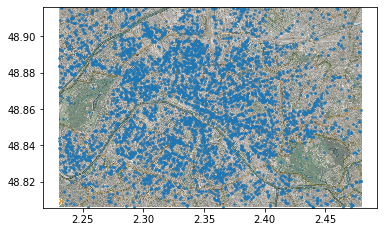

In [28]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("bar")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:, 0], geo_mat[:, 1], alpha=0.8, s=3)

## I - Méthode par histogramme

In [29]:
class Density(object):
    def fit(self,data):
        pass

    def predict(self,data):
        pass

    def score(self,data):     
        eps = 10e-10
        dens = self.predict(data) + eps
        return np.sum(np.log(dens))/data.shape[0]

In [30]:
class Histogramme(Density):
    def __init__(self,steps=10):
        Density.__init__(self)
        self.steps = steps

    def fit(self,x):
        H, _ = np.histogramdd(x,bins=self.steps)
        self.histo = H

    def to_bin(self,data):
        n = data.shape[0]
        xmin, xmax = data[:,0].min(), data[:,0].max()
        ymin, ymax = data[:,1].min(), data[:,1].max()
        deltax = (xmax-xmin)/self.steps
        deltay = (ymax-ymin)/self.steps

        res = []
        for i in range(n):
            xi = int((data[i,0]-xmin)/deltax)
            yi = int((data[i,1]-ymin)/deltay)
            if xi == self.steps:
                xi -= 1
            if yi == self.steps:
                yi -= 1
            res.append((xi,yi))
        return res,deltax,deltay

    def predict(self,x):
        n = x.shape[0] #nombre total de points
        ind,deltax,deltay = self.to_bin(x) #indices dans l'histogramme de chaque point
        V = deltax * deltay

        res = np.zeros(n) #vecteur des densites
        for i in range(n):
            cx,cy = ind[i]
            k = self.histo[cx,cy]
            res[i] = k
        return res/(n*V)



### Bakery

#### Visualisation pour quelques pas


Pour un pas = 10


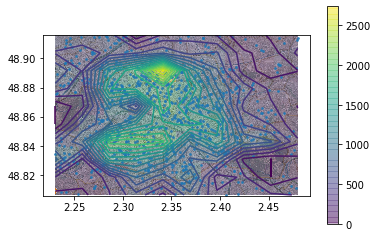

Pour un pas = 50


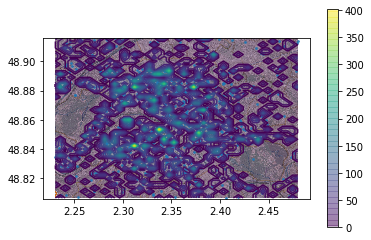

Pour un pas = 70


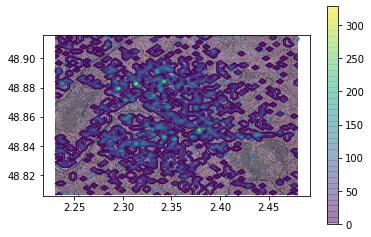

In [55]:
geo_mat, notes = load_poi("bakery")
geo_train, geo_test, notes_train, notes_test = train_test_split(geo_mat, notes, test_size=0.3, random_state=0)
save = False
if True:
    steps = [10,50,70]
    for s in steps:
        print("Pour un pas =", s)
        f = Histogramme(steps=s)
        f.fit(geo_train)
        show_density(f,geo_test,steps=f.steps)
        if save:
            plt.savefig("../fig/bakery_histo-dens_steps="+str(s))
        plt.show()


    

#### Calcul du meilleur step

Best step =  4 
Best score =  5.141560085157894


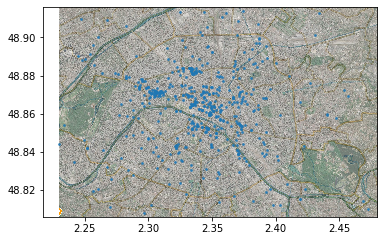

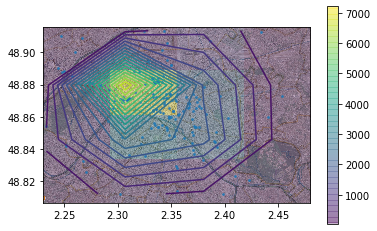

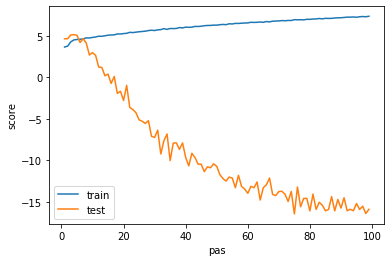

In [59]:
save = False
if True:
    steps = np.arange(1,100)
    best_steps = 0
    best_score = -np.inf
    scores_train = []
    scores_test = []
    for s in steps:
        f = Histogramme(steps=s)
        f.fit(geo_train)
        f_sc_train = f.score(geo_train)
        f_sc_test = f.score(geo_test)
        scores_train.append(f_sc_train)
        scores_test.append(f_sc_test)
        if best_score < f_sc_test:
            best_score = f_sc_test
            best_steps = s
    print("Best step = ",best_steps,"\nBest score = ",best_score)

    # Affichage
    show_carte = True
    show_dens = True
    courbes = True

    if show_carte:
        #plt.ion()
        plt.figure()
        # Affiche la carte de Paris
        show_img()
        # Affiche les POIs
        plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
        if save:
            plt.savefig("../fig/bakery_histo_carte")
    if show_dens:
        f = Histogramme(steps=best_steps)
        f.fit(geo_train)
        show_density(f,geo_test,steps=f.steps)
        if save:
            plt.savefig("../fig/bakery_histo_dens")
    if courbes:
        plt.figure()
        plt.plot(steps,scores_train,label="train")
        plt.plot(steps,scores_test,label="test")
        plt.legend()
        plt.xlabel("pas")
        plt.ylabel("score")
        if save:
            plt.savefig("../fig/bakery_histo_plot")
    plt.show()

### Night club

#### Visualisation pour quelques pas


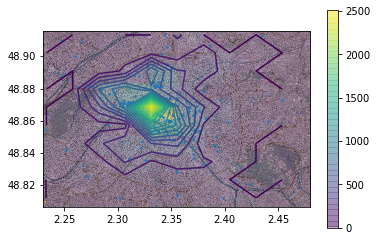

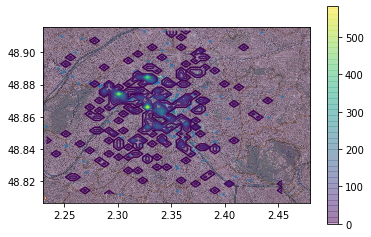

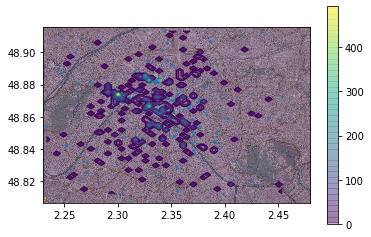

In [57]:
geo_mat, notes = load_poi("night_club")
geo_train, geo_test, notes_train, notes_test = train_test_split(geo_mat, notes, test_size=0.3, random_state=0)
save = False
if True:
    steps = [10,50,70]
    for s in steps:
        f = Histogramme(steps=s)
        f.fit(geo_train)
        show_density(f,geo_test,steps=f.steps)
        if save:
            plt.savefig("../fig/night_club_histo-dens_steps="+str(s))
    plt.show()


    

#### Calcul du meilleur step

Best step =  4 
Best score =  5.141560085157894


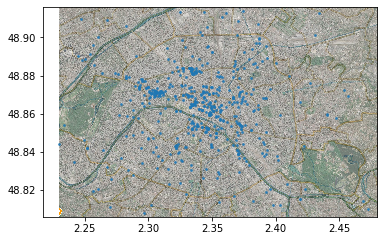

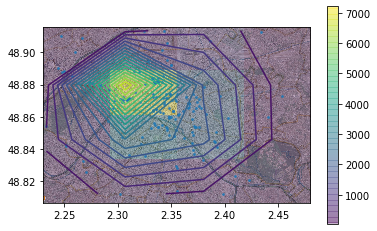

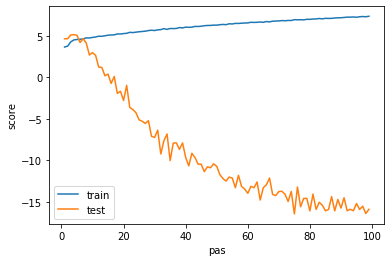

In [58]:
save = False
if True:
    steps = np.arange(1,100)
    best_steps = 0
    best_score = -np.inf
    scores_train = []
    scores_test = []
    for s in steps:
        f = Histogramme(steps=s)
        f.fit(geo_train)
        f_sc_train = f.score(geo_train)
        f_sc_test = f.score(geo_test)
        scores_train.append(f_sc_train)
        scores_test.append(f_sc_test)
        if best_score < f_sc_test:
            best_score = f_sc_test
            best_steps = s
    print("Best step = ",best_steps,"\nBest score = ",best_score)

    # Affichage
    show_carte = True
    show_dens = True
    courbes = True

    if show_carte:
        #plt.ion()
        plt.figure()
        # Affiche la carte de Paris
        show_img()
        # Affiche les POIs
        plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
        if save:
            plt.savefig("../fig/night_club_histo_carte")
    if show_dens:
        f = Histogramme(steps=best_steps)
        f.fit(geo_train)
        show_density(f,geo_test,steps=f.steps)
        if save:
            plt.savefig("../fig/night_club_histo_dens")
    if courbes:
        plt.figure()
        plt.plot(steps,scores_train,label="train")
        plt.plot(steps,scores_test,label="test")
        plt.legend()
        plt.xlabel("pas")
        plt.ylabel("score")
        if save:
            plt.savefig("../fig/night_club_histo_plot")
    plt.show()

### Validation croisée

#### Restaurant

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Meilleurs steps : 1


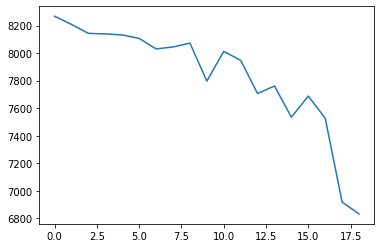

In [8]:
mean_list = []
steps_list = []
for steps in range(1, 20):
    geo_mat, notes = load_poi("restaurant")
    score_list = cross_val_score(Histogramme(steps=steps), geo_mat)
    mean_list.append(np.mean(score_list))
    steps_list.append(steps)
print("Meilleurs steps :", steps_list[np.argmax(mean_list)])
plt.plot(mean_list)

#### Night Club

Meilleurs steps : 1


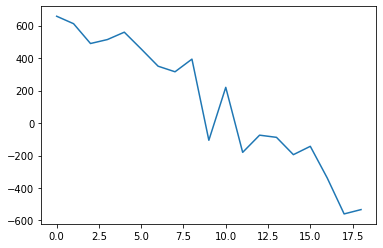

In [9]:
mean_list = []
steps_list = []
for steps in range(1, 20):
    geo_mat, notes = load_poi("night_club")
    score_list = cross_val_score(Histogramme(steps=steps), geo_mat)
    mean_list.append(np.mean(score_list))
    steps_list.append(steps)
print("Meilleurs steps :", steps_list[np.argmax(mean_list)])
plt.plot(mean_list)

## II - Méthodes à noyaux

In [37]:
class KernelDensity(Density):
    def __init__(self, kernel=None, sigma=0.1):
        Density.__init__(self)
        self.kernel = kernel
        self.sigma = sigma

    def fit(self, x):
        self.x = x

    def predict(self, data):
        # retourne la densité associée à chaque point de data
        n, d = self.x.shape
        l = []
        for x_i in data:
            x_i_stacked = np.vstack([x_i]*n)
            sum_value = self.kernel((x_i_stacked - self.x)/self.sigma).sum()
            l.append(sum_value / (n*self.sigma**d))
        return np.array(l)

#### Kernel gaussian

In [38]:
def kernel_gaussian(x):
    d = x.shape[-1]
    return np.exp(-0.5 * np.linalg.norm(x, axis=1)**2) * (2*np.pi)**(-d/2) 


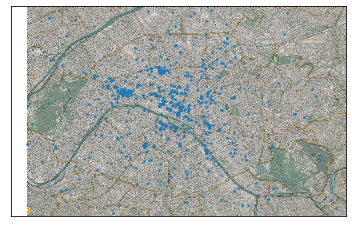

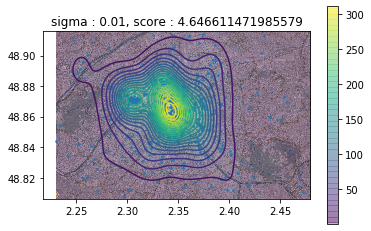

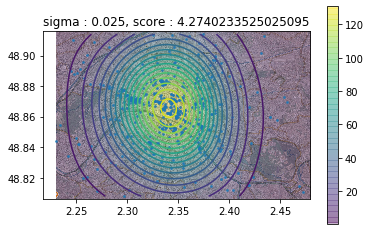

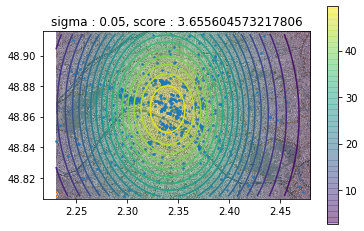

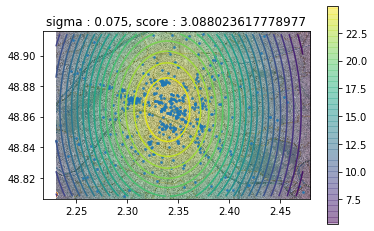

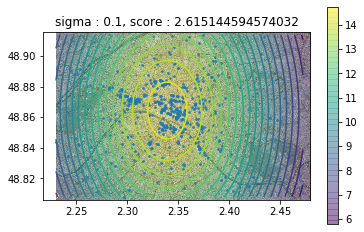

In [39]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for sigma in [0.01, 0.025, 0.05, 0.075, 0.1]:
    nc_kernelDensity = KernelDensity(kernel=kernel_gaussian, sigma=sigma)
    nc_kernelDensity.fit(geo_mat)
    show_density(nc_kernelDensity, geo_mat)
    plt.gca().set_title(f'sigma : {sigma}, score : {nc_kernelDensity.score(geo_mat)}')


#### Kernel uniforme

In [13]:
def kernel_uniform(x):
    bool_list = (np.abs(x) < 0.5).all(axis=1)
    return np.where(bool_list, 1, 0)

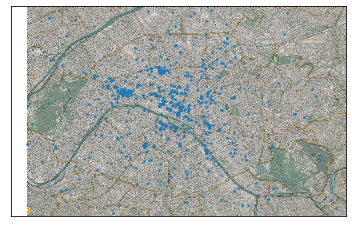

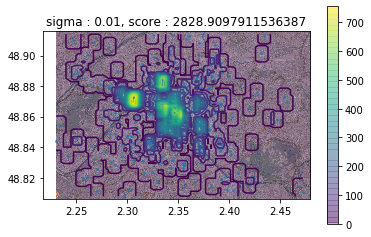

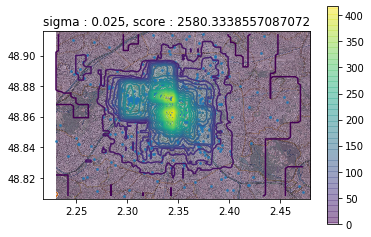

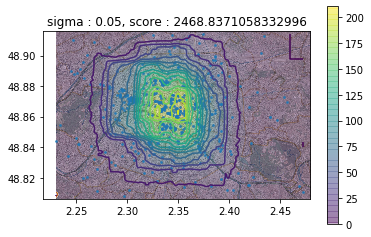

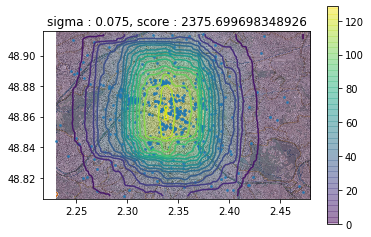

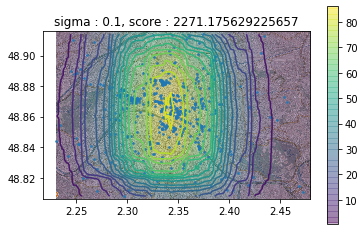

In [14]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for sigma in [0.01, 0.025, 0.05, 0.075, 0.1]:
    nc_kernelDensity = KernelDensity(kernel=kernel_uniform, sigma=sigma)
    nc_kernelDensity.fit(geo_mat)
    show_density(nc_kernelDensity, geo_mat)
    plt.gca().set_title(f'sigma : {sigma}, score : {nc_kernelDensity.score(geo_mat)}')

## III - Régression par Nadaraya-Watson

In [ ]:
class Nadaraya():
    